In [172]:
import os
import json
import gzip
import time
import random

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm

In [2]:
DATA_PATH = '../data/phone_data.json.gz'
RANDOM_SEED = 0

In [3]:
%matplotlib inline

In [4]:
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # tf 2.0+
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### Load data

In [5]:
def gzip2json(path):
    with gzip.GzipFile(path, 'r') as fin:
        data = json.loads(fin.read().decode('utf-8'))
    return data

In [6]:
data = gzip2json(DATA_PATH)

* chr(769) we are replacing stress near letters
* adding a for cases word transcription missed it, for such word like *-тися -> *-тись etc.

TODO: think about removing dash '-' as it has no phoneme at all

In [98]:
words, letters, phones = [], [], []

for item in tqdm(data):
    word = item['word'].lower()
    ltrs = [letter for letter in word]
    phns = [letter.replace(chr(769), '') for letter in item['phones']]
    if ltrs[-1] in ('а', 'я') and phns[-1] != "а":
        phns += "а"
        
    ltrs = ['<start>'] + ltrs + ['<end>']
    phns = ['<start>'] + phns + ['<end>']
    
    words.append(word)
    letters.append(ltrs)
    phones.append(phns)  

100%|██████████| 2274/2274 [00:00<00:00, 186398.94it/s]


In [99]:
data_preprocessed = list(zip(words, letters, phones))

In [100]:
sample = random.choice(data_preprocessed)
print(f'word: ', sample[0])
print(f'letters: ', sample[1])
print(f'phonemes: ', sample[2])

word:  азурит
letters:  ['<start>', 'а', 'з', 'у', 'р', 'и', 'т', '<end>']
phonemes:  ['<start>', 'а', 'з', 'у', 'р', 'и', 'т', '<end>']


### Preprocess

In [101]:
from sklearn.model_selection import train_test_split

In [102]:
def flatten(array):
    for item in array:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item

In [103]:
class SequenceTokenizer:
    
    def __init__(self):
        self.vocab = {}
        self.inverse_vocab = {}
        self.oov_token ='<UNK>'
        self.oov_token_index = 0
        
    def fit(self, sequence):
        self.inverse_vocab = dict(enumerate([self.oov_token] + sorted(set(flatten(sequence))), 1))
        self.vocab = {v:k for k,v in self.inverse_vocab.items()}
        self.oov_token_index = self.vocab.get(self.oov_token)
        return self
    
    def transform(self, X):
        res = []
        for line in X:
            res.append([self.vocab.get(item, self.oov_token_index) for item in line])
        return res

In [105]:
max_len_encoder = max(map(lambda x: len(x), letters))
max_len_decoder = max(map(lambda x: len(x), phones))
unique_phones = set(flatten(phones))
print(max_len_encoder, max_len_decoder)

32 31


In [106]:
tokenizer = SequenceTokenizer().fit(letters)

In [120]:
X = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.transform(letters), padding='post')
y = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.transform(phones), padding='post')

In [121]:
# X = np.expand_dims(X, axis=1)
# y = np.expand_dims(y, axis=1)

In [122]:
X.shape, y.shape

((2274, 32), (2274, 31))

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [124]:
X_train.shape, y_train.shape

((1819, 32), (1819, 31))

### Seq2seq LSTM

In [85]:
encoder_inputs = tf.keras.layers.Input(shape=(None, max_len_encoder))

encoder = tf.keras.layers.LSTM(128, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

In [86]:
decoder_inputs = tf.keras.layers.Input(shape=(None, max_len_decoder))

decoder_lstm = tf.keras.layers.LSTM(128, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = tf.keras.layers.Dense(len(unique_phones), activation='softmax')

decoder_outputs = decoder_dense(decoder_outputs)

In [87]:
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [88]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, verbose=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5, min_delta=1e-3, verbose=True), 
    tf.keras.callbacks.ModelCheckpoint(filepath='g2p_lstm.h5', save_best_only=True, verbose=True)
]

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, 30)]   0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None, 31)]   0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, 128), (None, 81408       input_11[0][0]                   
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, None, 128),  81920       input_12[0][0]                   
                                                                 lstm_10[0][1]              

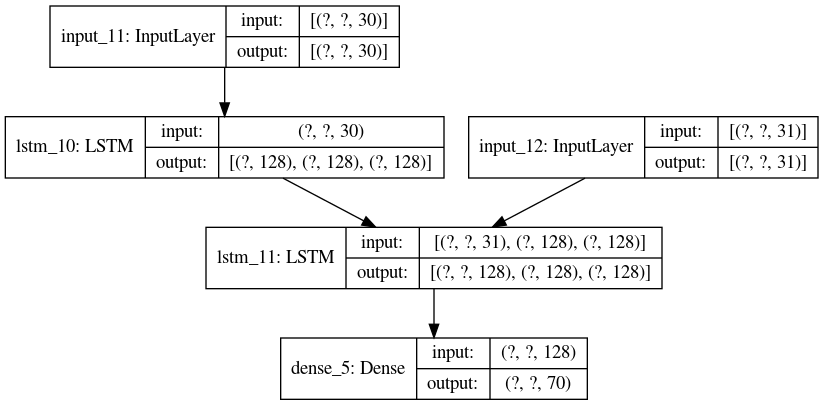

In [89]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [91]:
# history = model.fit(x=[X, y], y=y,
# #                     class_weight='balanced',
#                     epochs=2,
#                     batch_size=32,
#                     callbacks=callbacks,
# #                     validation_data=([X_dev, y_dev], y_dev),
#                     verbose=1)

### Seq2seq with Attention

In [95]:
train_input, test_input, train_output, test_output = X_train, X_test, y_train, y_test

In [125]:
BUFFER_SIZE = train_input.shape[0]
BUFFER_SIZE_VAL = test_input.shape[0]
BATCH_SIZE = 64
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
steps_per_epoch_val = BUFFER_SIZE_VAL // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_size = len(tokenizer.vocab) + 1

In [126]:
max_length_input, max_length_output = train_input.shape[1], train_output.shape[1]

In [127]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_output)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [128]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_output)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [129]:
example_input_batch, example_output_batch = next(iter(train_dataset))
example_input_batch.shape, example_output_batch.shape

(TensorShape([64, 30]), TensorShape([64, 31]))

In [130]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [131]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [132]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

In [134]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 30, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [135]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 30, 1)


In [136]:
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 39)


In [137]:
optimizer = tf.keras.optimizers.Adam()

In [138]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [139]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [145]:
@tf.function
def train_step(inp, out, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer.vocab['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the output as the next input
        for t in range(1, out.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(out[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(out[:, t], 1)

    batch_loss = (loss / int(out.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [146]:
@tf.function
def val_step(inp, out, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer.vocab['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the output as the next input
        for t in range(1, out.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(out[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(out[:, t], 1)

    batch_loss = (loss / int(out.shape[1]))

    return batch_loss

In [148]:
n_epochs = 2
history = {}

for epoch in range(1, n_epochs+1):
    start_time = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_val_loss = 0
    
    print(f"Epoch {epoch}/{n_epochs}")
    
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    for (batch, (inp, targ)) in enumerate(test_dataset.take(steps_per_epoch)):
        batch_loss = val_step(inp, targ, enc_hidden)
        total_val_loss += batch_loss
    
    print('loss: {loss:.4f}\tval_loss: {val_loss:.4f}\texec_time: {exec_time:.2f} seconds\n'.format(
            loss = total_loss / steps_per_epoch, 
            val_loss = total_val_loss / steps_per_epoch_val,
            exec_time = time.time() - start_time))
    
    history['train'] = history.get('train', []) + [total_loss.numpy() / steps_per_epoch]
    history['val'] = history.get('val', []) + [total_val_loss.numpy() / steps_per_epoch_val]
            
#     saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 1/2
loss: 0.3798	val_loss: 0.2585	exec_time: 54.14 seconds

Epoch 2/2
loss: 0.1785	val_loss: 0.1382	exec_time: 56.63 seconds



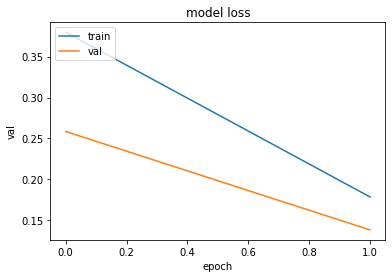

In [149]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.title('model loss')
plt.ylabel('val')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [150]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [182]:
def evaluate(word):
    
    ltrs = [letter for letter in word]
    ltrs = ['<start>'] + ltrs + ['<end>']
    
    attention_plot = np.zeros((max_length_output, max_length_input))

    inputs = tokenizer.transform([ltrs])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=max_length_input,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.vocab['<start>']], 0)

    for t in range(max_length_output):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tokenizer.inverse_vocab[predicted_id] + ' '

        if tokenizer.inverse_vocab[predicted_id] == '<end>':
            return result, word, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, word, attention_plot

In [183]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    

def paraphrase(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted paraphrase: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [184]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [185]:
evaluate('аахен')[0].replace('<end>', '').strip()

'с а ж з с а ж з с а ж з с а ж з с а ж з с а ж з с а ж з с а ж'

Input: аахен
Predicted paraphrase: с а ж з с а ж з с а ж з с а ж з с а ж з с а ж з с а ж з с а ж 


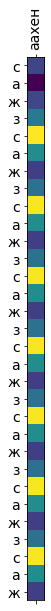

In [188]:
paraphrase('аахен')